        Month    TotalSales
0  2010-12-01  4.893286e+05
1  2011-01-01  1.538408e+06
2  2011-03-01  2.010618e+06
3  2011-05-01  4.027080e+06
4  2011-07-01  7.131167e+05


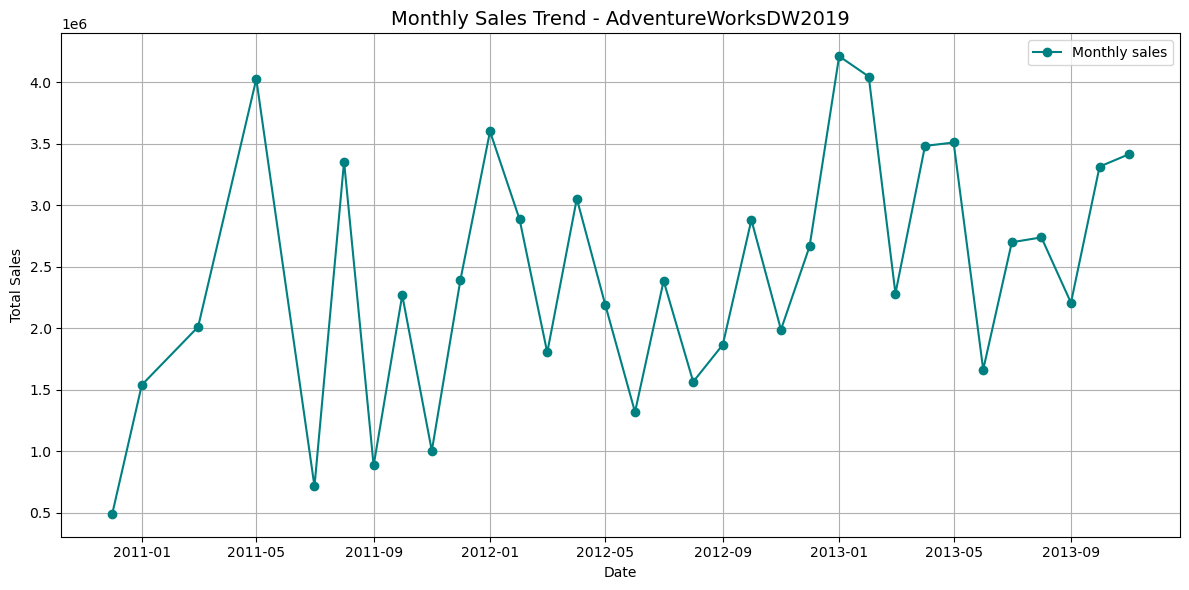

In [61]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

# Connection parameters
server = r'RODOLFO\SQLEXPRESS'
database = 'AdventureWorksDW2019'
driver = 'ODBC Driver 17 for SQL Server'

# Create connection string
connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver}&trusted_connection=yes"

# Create engine
engine = create_engine(connection_string)

# ✅ Define the query BEFORE executing it
query = """
SELECT 
    CAST(FORMAT(OrderDate, 'yyyy-MM-01') AS DATE) AS Month,
    SUM(SalesAmount) AS TotalSales
FROM FactResellerSales
GROUP BY CAST(FORMAT(OrderDate, 'yyyy-MM-01') AS DATE)
ORDER BY Month
"""

# Execute and get DataFrame
df = pd.read_sql(query, engine)


print(df.head())
#df.to_csv(r'C:\Users\Rodol\Downloads\mi_archivo1.csv', index=False)


df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Line graph: monthly sales
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['TotalSales'], marker='o', linestyle='-', color='teal', label='Monthly sales')
plt.title('Monthly Sales Trend - AdventureWorksDW2019', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Outliers según Z-score en SalesAmount:
  Product  SalesAmount  SalesAmount_zscore
0   Prod1       5000.0            9.071488

Outliers según Z-score en ListPrice:
  Product  ListPrice  ListPrice_zscore
1   Prod2      150.0          7.195028

Outliers según IQR en SalesAmount:
   Product  SalesAmount
0    Prod1  5000.000000
74  Prod75   476.050979

Outliers según IQR en ListPrice:
   Product   ListPrice
1    Prod2  150.000000
79  Prod80   77.201692


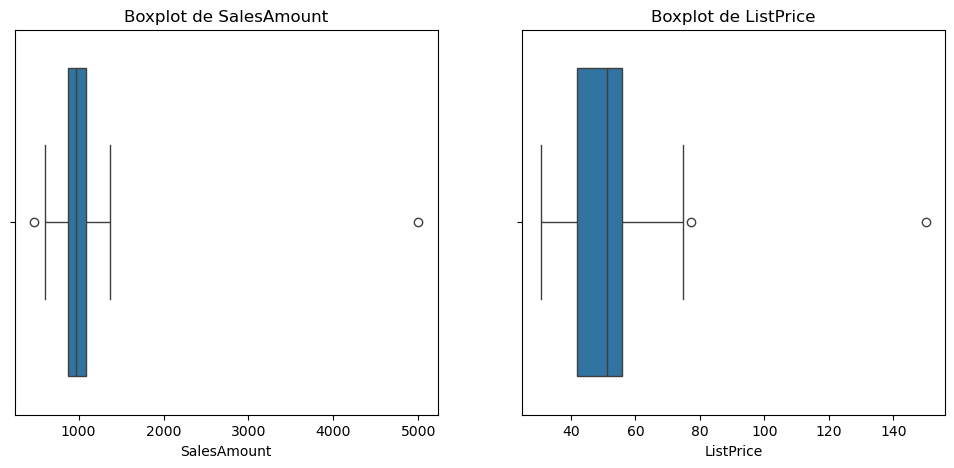

In [59]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Crear dataframe 
np.random.seed(42)
df = pd.DataFrame({
    'Product': ['Prod' + str(i) for i in range(1, 101)],
    'SalesAmount': np.random.normal(loc=1000, scale=200, size=100),
    'ListPrice': np.random.normal(loc=50, scale=10, size=100)
})

# add outliers 
df.loc[0, 'SalesAmount'] = 5000
df.loc[1, 'ListPrice'] = 150

# --- Método 1: Z-score ---
df['SalesAmount_zscore'] = stats.zscore(df['SalesAmount'])
df['ListPrice_zscore'] = stats.zscore(df['ListPrice'])

z_threshold = 3
outliers_z_sales = df[np.abs(df['SalesAmount_zscore']) > z_threshold]
outliers_z_price = df[np.abs(df['ListPrice_zscore']) > z_threshold]

print("Outliers según Z-score en SalesAmount:")
print(outliers_z_sales[['Product', 'SalesAmount', 'SalesAmount_zscore']])

print("\nOutliers según Z-score en ListPrice:")
print(outliers_z_price[['Product', 'ListPrice', 'ListPrice_zscore']])

# --- Método 2: IQR ---
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

outliers_iqr_sales = detect_outliers_iqr(df, 'SalesAmount')
outliers_iqr_price = detect_outliers_iqr(df, 'ListPrice')

print("\nOutliers según IQR en SalesAmount:")
print(outliers_iqr_sales[['Product', 'SalesAmount']])

print("\nOutliers según IQR en ListPrice:")
print(outliers_iqr_price[['Product', 'ListPrice']])

# --- Visualización ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='SalesAmount')
plt.title('Boxplot de SalesAmount')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='ListPrice')
plt.title('Boxplot de ListPrice')

plt.show()



In [15]:
# Query to obtain total sales, cost and margin by product
query_segmentacion = """
SELECT 
    p.EnglishProductName AS ProductName,
    SUM(s.SalesAmount) AS TotalSales,
    SUM(s.TotalProductCost) AS TotalCost,
    SUM(s.SalesAmount - s.TotalProductCost) AS GrossProfit
FROM FactResellerSales s
JOIN DimProduct p ON s.ProductKey = p.ProductKey
GROUP BY p.EnglishProductName
HAVING SUM(s.SalesAmount) > 0
"""

# Execute and load to the DataFrame
df_segment = pd.read_sql(query_segmentacion, engine)

# Show the first 5 records
df_segment.head()

,ProductName,TotalSales,TotalCost,GrossProfit
0,AWC Logo Cap,31541.3461,37272.8044,-5731.4583
1,Bike Wash - Dissolver,11188.3725,7168.6263,4019.7462
2,Cable Lock,16225.2200,11199.3750,5025.8450
3,Chain,9377.7102,6955.6284,2422.0818
4,"Classic Vest, L",457.2000,284.9880,172.2120


In [43]:
# Calculate the gross margin percentage
df_segment['GrossMargin%'] = df_segment['GrossProfit'] / df_segment['TotalSales']

# Create a basic segmentation:
# - Top Seller: high in sales
# - High Margin: high in margin
# - Others

# Define thresholds using percentiles (adjustable)
sales_threshold = df_segment['TotalSales'].quantile(0.75)
margin_threshold = df_segment['GrossMargin%'].quantile(0.75)

# Classify products
def classify_product(row):
    if row['TotalSales'] >= sales_threshold and row['GrossMargin%'] >= margin_threshold:
        return 'Top Seller + High Margin'
    elif row['TotalSales'] >= sales_threshold:
        return 'Top Seller'
    elif row['GrossMargin%'] >= margin_threshold:
        return 'High Margin'
    else:
        return 'Others'

df_segment['Segment'] = df_segment.apply(classify_product, axis=1)

df_segment.head()

,ProductName,TotalSales,TotalCost,GrossProfit,GrossMargin%,Segmento,Segment,Seddgment
0,AWC Logo Cap,31541.3461,37272.8044,-5731.4583,-0.181713,Otros,Others,Others
1,Bike Wash - Dissolver,11188.3725,7168.6263,4019.7462,0.359279,High Margin,High Margin,High Margin
2,Cable Lock,16225.2200,11199.3750,5025.8450,0.309755,High Margin,High Margin,High Margin
3,Chain,9377.7102,6955.6284,2422.0818,0.258281,Otros,Others,Others
4,"Classic Vest, L",457.2000,284.9880,172.2120,0.376667,High Margin,High Margin,High Margin


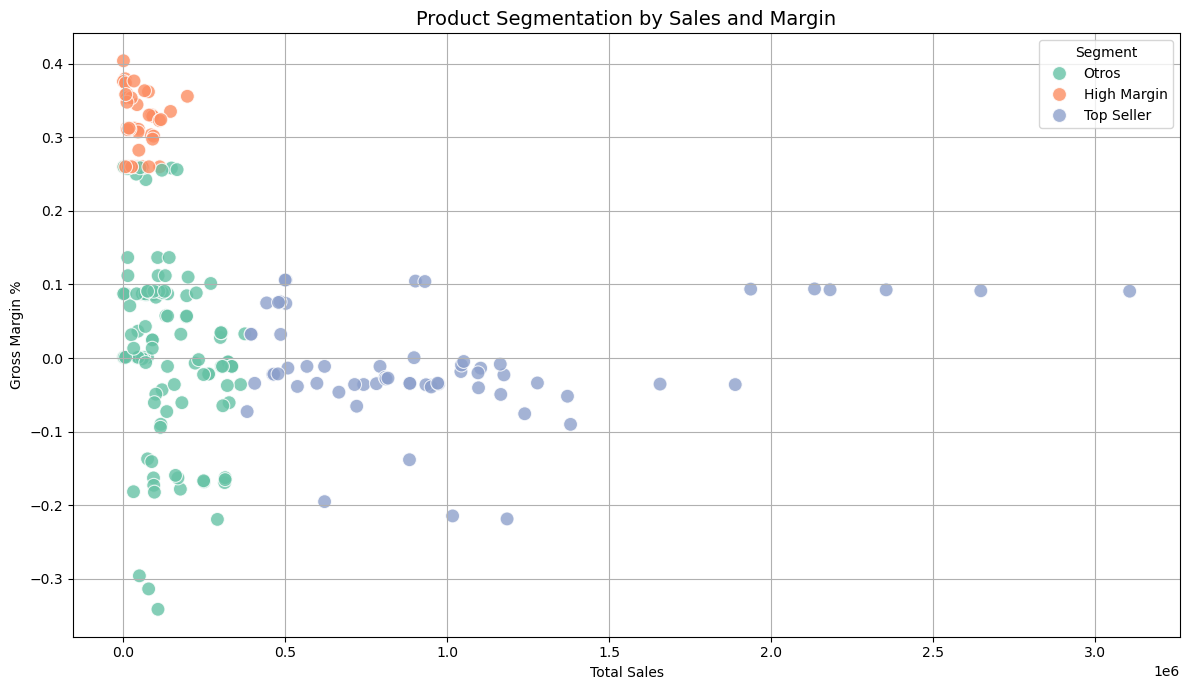

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_segment,
    x='TotalSales',
    y='GrossMargin%',
    hue='Segmento',
    palette='Set2',
    s=100,
    alpha=0.8
)

plt.title('Product Segmentation by Sales and Margin', fontsize=14)
plt.xlabel('Total Sales')
plt.ylabel('Gross Margin %')
plt.grid(True)
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np

def clean_dimreseller(df):
    """
    Data cleaning pipeline for the DimReseller table.
    """

    # 1. Remove duplicate rows based on 'ResellerName'
    df_clean = df.drop_duplicates(subset=['ResellerName'])

    # 2. Drop rows where 'AnnualSales' is null
    df_clean = df_clean.dropna(subset=['AnnualSales'])

    # 3. Replace specific values like 'NA' and 'Unknown' with NaN in 'BusinessType'
    df_clean['BusinessType'] = df_clean['BusinessType'].replace(['NA', 'Unknown'], np.nan)

    # 4. Filter only 'Specialty Bike Shop' business types
    df_clean = df_clean[df_clean['BusinessType'] == 'Specialty Bike Shop']

    # 5. Create a conditional column to classify sales level
    # Define thresholds using quantiles
    high_sales_threshold = df_clean['AnnualSales'].quantile(0.75)
    low_sales_threshold = df_clean['AnnualSales'].quantile(0.25)

    def classify_sales(sales):
        if sales >= high_sales_threshold:
            return 'High'
        elif sales <= low_sales_threshold:
            return 'Low'
        else:
            return 'Medium'
*/*
    df_clean['SalesLevel'] = df_clean['AnnualSales'].apply(classify_sales)

    return df_clean

# Load data
query_reseller = "SELECT * FROM DimReseller"
df_reseller = pd.read_sql(query_reseller, engine)

# Apply cleaning pipeline
df_reseller_clean = clean_dimreseller(df_reseller)

# Show cleaned data
print(df_reseller_clean.head())
#df.to_csv(r'C:\Users\Rodol\Downloads\mi_archivo.csv', index=False)


    ResellerKey  GeographyKey ResellerAlternateKey                Phone  \
1             2           635           AW00000002         170-555-0127   
4             5           322           AW00000005         828-555-0186   
7             8           409           AW00000008         872-555-0171   
10           11            96           AW00000011         926-555-0159   
13           14           167           AW00000014  1 (11) 500 555-0167   

           BusinessType                ResellerName  NumberEmployees  \
1   Specialty Bike Shop          Progressive Sports               10   
4   Specialty Bike Shop  Metropolitan Sports Supply               13   
7   Specialty Bike Shop            Exemplary Cycles               16   
10  Specialty Bike Shop                 Sharp Bikes               19   
13  Specialty Bike Shop      Bicycle Warehouse Inc.               22   

   OrderFrequency  OrderMonth  FirstOrderYear  ...  ProductLine  \
1               A         5.0          2012.0  ..